# Vignetting analysis for EPIC

This analysis follows on a couple of early studies:

* Statistical evaluation of the flux cross-calibration of the XMM-EPIC ([Mateos et al. 2009](https://ui.adsabs.harvard.edu/abs/2009A%26A...496..879M/abstract));
* The non-linear X-ray/UV relation in AGNs: contribution of instrumental effects on the X-ray variability ([Elisabeta Lusso, 2018](https://ui.adsabs.harvard.edu/abs/2019AN....340..267L/abstract)).


**NOTES:** 
1. This notebook will read the 3XMM-DR8 catalogue with the added azymuthal angle from my calculations.
2. In this notebook (`work6`) all the analysis is based on sources detected at MOS1 off-axis angles greater than 2 arcmin. And all the fluxes are de-vignetted, i.e. `flux_new = flux * vignetting`, for each instrument.

_20 Aug 2019_

In [10]:
import os

import numpy as np

from astropy.table import Table
import pandas as pd
from scipy.stats import sem
#import altair as alt

%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm
#
import seaborn as sns
sns.set(style="white")

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

home = os.path.expanduser('~')

## Energy bands used in 3XMM

```Basic energy bands: 	
1 	= 	0.2 -   0.5 keV 	 
2 	= 	0.5 -   1.0 keV 	  	 
3 	= 	1.0 -   2.0 keV 	  	 
4 	= 	2.0 -   4.5 keV 	  	 
5 	= 	4.5 - 12.0 keV 	  	 
Broad energy bands: 	
6 	= 	0.2 -   2.0 keV 	  	soft band, no images made, not used
7 	= 	2.0 - 12.0 keV 	  	hard band, no images made, not used
8 	= 	0.2 - 12.0 keV 	  	total band
9 	= 	0.5 -   4.5 keV 	  	XID band
```

In [2]:
#
# define the energy ranges for info
#
full_bands = {1:'[0.2-0.5] keV',2:'[0.5-1.0] keV',3:'[1.0-2.0] keV',4:'[2.0-4.5] keV',5:'[4.5-12.0] keV',\
        8:'[0.2-12.0] keV'}

In [3]:
#
# read the 3XMM-DR8 catalogue
#
wdir = f"{home}/XMM/3XMM"
#t3 = Table.read(f'{wdir}/3XMM_DR8cat_v1.0.fits.gz')
#
# my version with the azymuthal angle for the detections
#
t3 = Table.read(f'{wdir}/3XMM_DR8cat_v1.1_azymuth.fits.gz')

## Source selection

We apply the following selection of sources from the `3XMM-DR8` catalogue, where `x` is one of `M1, M2` or `PN`:
1. good detection, i.e. `SUM_FLAG == 0`
2. point-like sources, i.e. `EP_EXTENT == 0`
3. at off-axis angles <= 12 arcmin, i.e. `x_OFFAX <= 12` and `M1_OFFAX >= 2.0`
4. flux in [2,12] keV <= 6.0e-12 erg/cm2/s, i.e. `(x_4_FLUX + x_5_FLUX) <= 6.0e-12`, in order to avoid pile-up sources.
5. `CONFUSED == false`
6. `HIGH_BACKGROUND == false`
7. at least 200 source counts in band 8, i.e. `EP_8_CTS >= 200`
8. not too faint sources, i.e. `x_5_FLUX >= 1.0e-15`
9. High SNR in band 5, i.e. `x_5_FLUX/x_5_FLUX_ERR >= 5`

In [4]:
ntot = len(t3)
m1 = t3['SUM_FLAG'] == 0
#
m2 = t3['EP_EXTENT'] == 0
#
m3_m1 = t3['M1_OFFAX'] <= 12.0
m3_m1x = t3['M1_OFFAX'] >= 2.0
#
m3_m2 = t3['M2_OFFAX'] <= 12.0
m3_pn = t3['PN_OFFAX'] <= 12.0
#
m4_m1 = (t3['M1_4_FLUX'] + t3['M1_5_FLUX']) <= 6.0e-12
m4_m2 = (t3['M2_4_FLUX'] + t3['M2_5_FLUX']) <= 6.0e-12
m4_pn = (t3['PN_4_FLUX'] + t3['PN_5_FLUX']) <= 6.0e-12
#
m5 = t3['CONFUSED'] == 0
#
m6 = t3['HIGH_BACKGROUND'] == 0
#
m7 = t3['EP_8_CTS'] >= 200.0
#
m8_m1 = (t3['M1_5_FLUX']) >= 1.0e-15
m8_m2 = (t3['M2_5_FLUX']) >= 1.0e-15
m8_pn = (t3['PN_5_FLUX']) >= 1.0e-15
#
m9_m1 = (t3['M1_5_FLUX']/t3['M1_5_FLUX_ERR']) >= 5.0
m9_m2 = (t3['M2_5_FLUX']/t3['M2_5_FLUX_ERR']) >= 5.0
m9_pn = (t3['PN_5_FLUX']/t3['PN_5_FLUX_ERR']) >= 5.0
#
#xfilter = m1*m2*m3_m1*m3_m2*m3_pn*m4_m1*m4_m2*m4_pn*m5*m6*m7*m8_m1*m8_m2*m8_pn*m9_m1*m9_m2*m9_pn
xfilter = m1*m2*m3_m1*m3_m1x*m3_m2*m3_pn*m4_m1*m4_m2*m4_pn*m5*m6*m7
#
ix = np.where(xfilter)[0]
nx = len(ix)
print (f"Found {nx} out of {ntot} ({100*nx/ntot:.2f} %) 3XMM-DR8 sources with the filtering criteria.")

/home/ivaltchanov/miniconda3/envs/pyxspec/lib/python3.6/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)
/home/ivaltchanov/miniconda3/envs/pyxspec/lib/python3.6/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, op)(other)


Found 47457 out of 775153 (6.12 %) 3XMM-DR8 sources with the filtering criteria.


In [5]:
#
# extract the selection as a table
#
tsel = t3[ix]

## Flux difference as a function of the azymuthal angle

All flux diffs per band and M1 azymuth angle


In [13]:
t = Table.read(f'{wdir}/m1_vig_1000ev_3min.dat',format='ascii.fast_no_header')
# normalise to have max = 0 and convert to percantage
runphi = t['col1']
vig1_3 = (t['col2'] - np.max(t['col2']))*100.0
#
t = Table.read(f'{wdir}/m1_vig_10000ev_3min.dat',format='ascii.fast_no_header')
vig10_3 = (t['col2'] - np.max(t['col2']))*100.0
#
t = Table.read(f'{wdir}/m1_vig_1000ev_10min.dat',format='ascii.fast_no_header')
vig1_10 = (t['col2'] - np.max(t['col2']))*100.0
#
t = Table.read(f'{wdir}/m1_vig_10000ev_10min.dat',format='ascii.fast_no_header')
vig10_10 = (t['col2'] - np.max(t['col2']))*100.0


## Per band plots, only for PN vs MOS1

**NOTE:** fluxes de-vignetted.

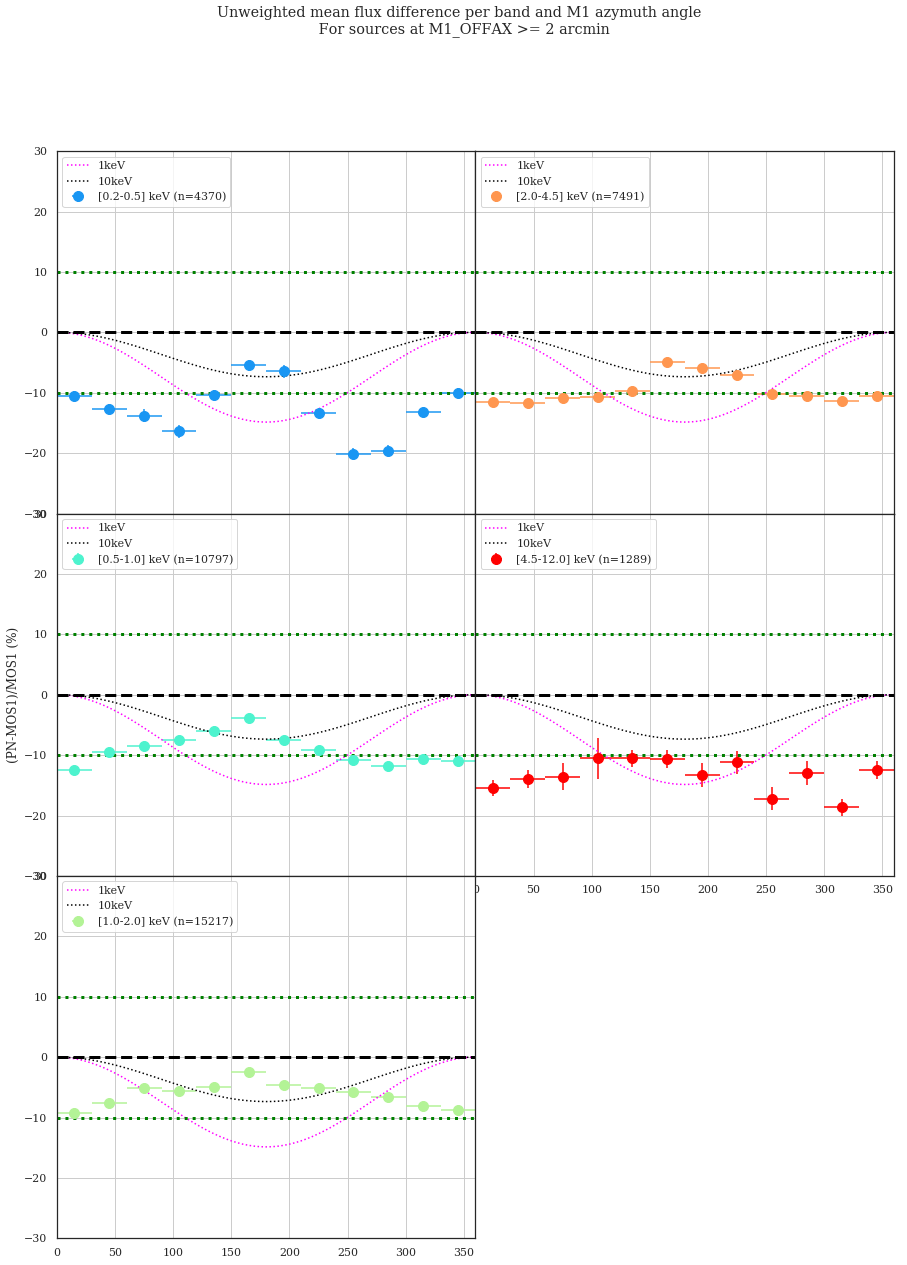

In [14]:
#
qtsel = {}
fig, axs = plt.subplots(3,2,figsize=(15,20))
#
# azymuthal angle ranges, step 30 deg
xazy = np.arange(0,390,30)
nz = len(xazy)
bands = np.array([1,2,3,4,5])
xcol = cm.rainbow(np.linspace(0, 1, 6))
#xcol = cm.rainbow(np.linspace(0, 1, nz-1))
#
# read the MOS vignetting functions from XMM-SAS calview, there are 4 curves: at 1 and 10 keV and at 3 arcmin and 10 arcmin
#
#
for xband in [1,2,3,4,5]:
    #
    # only select those sources at off-axis angles greater than 2 arcmin
    #
    q1_m1 = (tsel[f'M1_{xband}_FLUX']) >= 1.0e-15
    q1_m2 = (tsel[f'M2_{xband}_FLUX']) >= 1.0e-15
    q1_pn = (tsel[f'PN_{xband}_FLUX']) >= 1.0e-15
    #
    q2_m1 = (tsel[f'M1_{xband}_FLUX']/tsel[f'M1_{xband}_FLUX_ERR']) >= 5.0
    q2_m2 = (tsel[f'M2_{xband}_FLUX']/tsel[f'M2_{xband}_FLUX_ERR']) >= 5.0
    q2_pn = (tsel[f'PN_{xband}_FLUX']/tsel[f'PN_{xband}_FLUX_ERR']) >= 5.0
    #
    qfilter = q1_m1 & q1_m2 & q1_pn & q2_m1 & q2_m2 & q2_pn
    qtsel[xband] = tsel[qfilter]
    #
    m1_off = qtsel[xband][f'M1_OFFAX']
    #
    qwork = qtsel[xband].to_pandas()
    qwork = qwork[m1_off >= 2.0]
    nqwork = len(qwork)
    #print (f"Band: {xband}, selected {nqwork} at M1_OFFAX >= 2 arcmin")
    #
    m1_az = qwork[f'M1_phi']
    m2_az = qwork[f'M2_phi']
    #
    m1_fx = qwork[f'M1_{xband}_FLUX']*qwork[f'M1_{xband}_VIG']
    m2_fx = qwork[f'M2_{xband}_FLUX']*qwork[f'M2_{xband}_VIG']
    pn_fx = qwork[f'PN_{xband}_FLUX']*qwork[f'PN_{xband}_VIG']
    #
    m1_fx_err = qwork[f'M1_{xband}_FLUX_ERR']*qwork[f'M1_{xband}_VIG']
    m2_fx_err = qwork[f'M2_{xband}_FLUX_ERR']*qwork[f'M2_{xband}_VIG']
    pn_fx_err = qwork[f'PN_{xband}_FLUX_ERR']*qwork[f'PN_{xband}_VIG']
    #
    # now the ratios and their errors
    #
    ratio1 = (pn_fx/m1_fx - 1.0)*100.0 # in percents
    ratio1_err = np.abs(ratio1)*np.sqrt((m1_fx/m1_fx_err)**2 + (pn_fx/pn_fx_err)**2)
    ratio2 = (pn_fx/m2_fx - 1.0)*100.0 # in percents
    ratio2_err = np.abs(ratio2)*np.sqrt((m2_fx/m2_fx_err)**2 + (pn_fx/pn_fx_err)**2)
    ratio3 = (m2_fx/m1_fx - 1.0)*100.0 # in percents
    ratio3_err = np.abs(ratio3)*np.sqrt((m1_fx/m1_fx_err)**2 + (m2_fx/m2_fx_err)**2)
    #
    # now loop over the azymuths
    #
    rstep = 30.0
    run_az = np.arange(0,390,rstep)
    nep = len(run_az)
    #
    xaz1 = []
    xaz2 = []
    erat1 = []
    erat2 = []
    erat3 = []
    erat1_err = []
    erat2_err = []
    erat3_err = []
    #
    for j in np.arange(nep-1):
        e0 = run_az[j]
        e1 = run_az[j+1]
        ix1 = np.where((m1_az <= e1) & (m1_az > e0))[0]
        if (len(ix1) > 0):
            xaz1.append((e0+e1)/2.0)
            erat1.append(np.mean(ratio1[ix1]))
            erat3.append(np.mean(ratio3[ix1]))
            #erat1_err.append(np.std(ratio1[ix1]))
            #erat3_err.append(np.std(ratio3[ix1]))
            erat1_err.append(sem(ratio1[ix1]))
            erat3_err.append(sem(ratio3[ix1]))
        ix2 = np.where((m2_az <= e1) & (m2_az > e0))[0]
        if (len(ix2) > 0):
            xaz2.append((e0+e1)/2.0)
            erat2.append(np.mean(ratio2[ix2]))
            erat2_err.append(sem(ratio2[ix2]))
            #erat2_err.append(np.std(ratio2[ix2]))
    #
    irow = xband-1
    icol = 0
    if (irow > 2):
        icol=1
        irow=irow-3
    panel = irow,icol
    axs[panel].errorbar(xaz1,erat1,xerr=rstep/2.0,yerr=erat1_err,fmt='o',markersize=10,color=xcol[xband],\
                        label=f'{full_bands[xband]} (n={nqwork})')
    #
    # now the vignetting function
    #
    #axs[1].errorbar(xband,xmed2,yerr=(xmed2-xlow2,xup2-xmed2),fmt='o',markersize=10)
    #axs[1].errorbar(xaz2,erat2,xerr=rstep/2.0,yerr=erat2_err,fmt='o',markersize=10,color=xcol[xband],label=f'Band: {xband}')
    #
    #axs[2].errorbar(xband,xmed3,yerr=(xmed3-xlow3,xup3-xmed3),fmt='o',markersize=10)
    #axs[2].errorbar(xaz1,erat3,xerr=rstep/2.0,yerr=erat3_err,fmt='o',markersize=10,color=xcol[xband],label=f'Band: {xband}')
    #
    #
    # the MOS vignetting function from CCF/calview
    #
    axs[panel].plot(runphi,vig1_10,color='magenta',linestyle='dotted',label="1keV")
    axs[panel].plot(runphi,vig10_10,color='black',linestyle='dotted',label="10keV")
    ###########
    axs[panel].axhline(0.0,color='black',linestyle='--',linewidth=3)
    axs[panel].axhline(-10.0,color='green',linestyle='dotted',linewidth=3)
    axs[panel].axhline(10.0,color='green',linestyle='dotted',linewidth=3)
    axs[panel].grid()
    axs[panel].legend(loc='upper left')
    #axs[panel].set_xlabel('Energy band')
    if (irow==1 and icol==0):
        axs[panel].set_ylabel('(PN-MOS1)/MOS1 (%)')
    #axs[0].set_xticks(xband, minor=False)
    axs[panel].set_ylim((-30,30))
    axs[panel].set_xlim((0,360))
    if (icol > 0):
        axs[panel].set_yticklabels([])
    if (irow == 0 or (irow==1 and icol==0)):
        axs[panel].set_xticklabels([])
    #if (irow==0 and icol==0):
    #    axs[panel].set_title('Unweighted mean flux difference per band and M1 azymuth angle \n For sources at M1_OFFAX >= 2 arcmin')
#
plt.suptitle('Unweighted mean flux difference per band and M1 azymuth angle \n For sources at M1_OFFAX >= 2 arcmin')
plt.subplots_adjust(wspace=0, hspace=0)
fig.delaxes(axs[2,1])
#plt.savefig(f"{wdir}/3xmm_results_azymuth_mos1_pn.png",dpi=100)
plt.show()
plt.close();

## Per band plots, only for PN vs MOS2

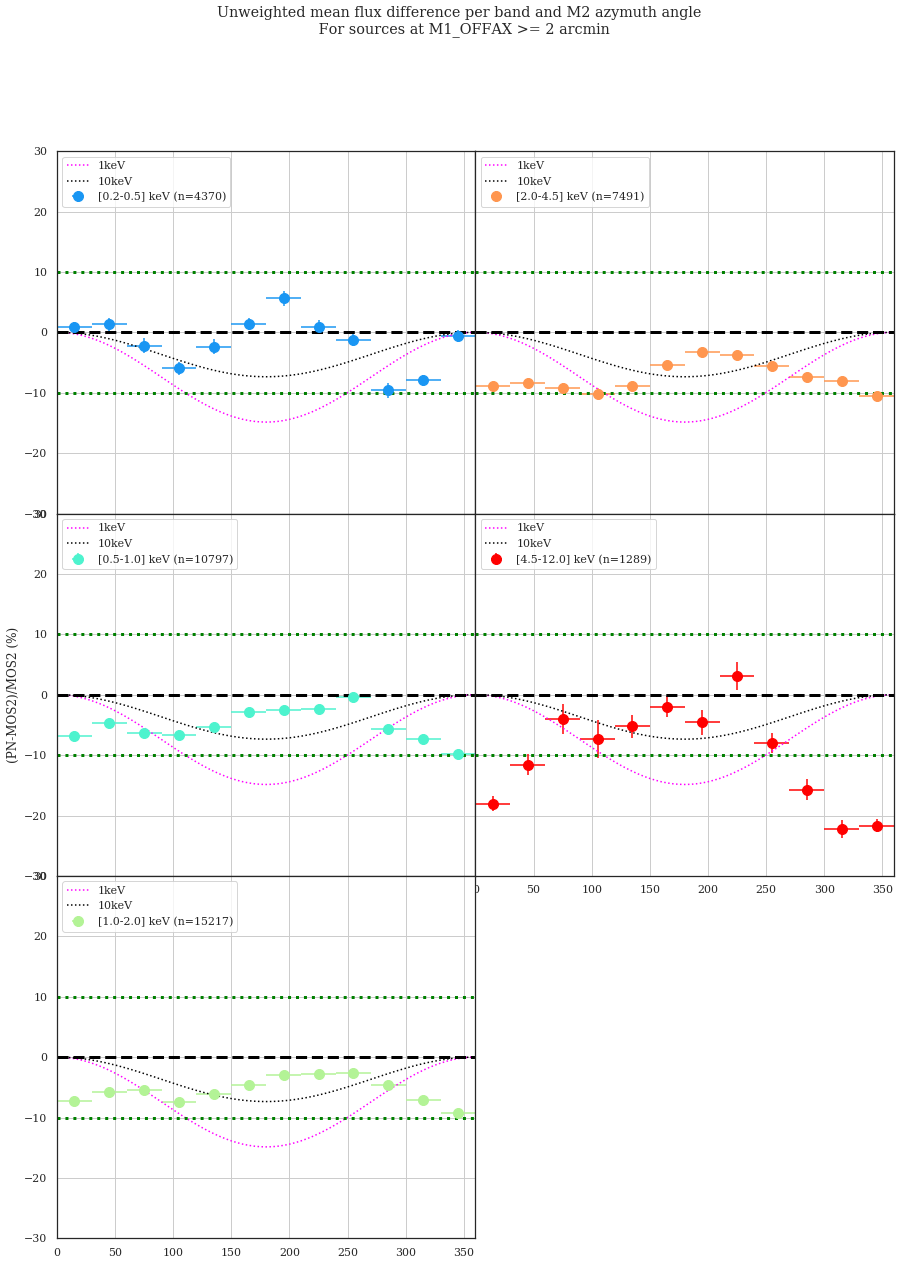

In [171]:
#
fig, axs = plt.subplots(3,2,figsize=(15,20))
#
# azymuthal angle ranges, step 30 deg
xazy = np.arange(0,390,30)
nz = len(xazy)
bands = np.array([1,2,3,4,5])
xcol = cm.rainbow(np.linspace(0, 1, 6))
#xcol = cm.rainbow(np.linspace(0, 1, nz-1))
#
# read the MOS vignetting functions from XMM-SAS calview, there are 4 curves: at 1 and 10 keV and at 3 arcmin and 10 arcmin
#
#
for xband in [1,2,3,4,5]:
    #
    # only select those sources at off-axis angles greater than 2 arcmin
    #
    m1_off = qtsel[xband][f'M1_OFFAX']
    qwork = qtsel[xband].to_pandas()
    qwork = qwork[m1_off >= 2.0]
    nqwork = len(qwork)
    #print (f"Band: {xband}, selected {nqwork} at M1_OFFAX >= 2 arcmin")
    #
    m1_az = qwork[f'M1_phi']
    m2_az = qwork[f'M2_phi']
    #
    m1_fx = qwork[f'M1_{xband}_FLUX']
    m2_fx = qwork[f'M2_{xband}_FLUX']
    pn_fx = qwork[f'PN_{xband}_FLUX']
    #
    m1_fx_err = qwork[f'M1_{xband}_FLUX_ERR']
    m2_fx_err = qwork[f'M2_{xband}_FLUX_ERR']
    pn_fx_err = qwork[f'PN_{xband}_FLUX_ERR']
    #
    # now the ratios and their errors
    #
    ratio1 = (pn_fx/m1_fx - 1.0)*100.0 # in percents
    ratio1_err = np.abs(ratio1)*np.sqrt((m1_fx/m1_fx_err)**2 + (pn_fx/pn_fx_err)**2)
    ratio2 = (pn_fx/m2_fx - 1.0)*100.0 # in percents
    ratio2_err = np.abs(ratio2)*np.sqrt((m2_fx/m2_fx_err)**2 + (pn_fx/pn_fx_err)**2)
    ratio3 = (m2_fx/m1_fx - 1.0)*100.0 # in percents
    ratio3_err = np.abs(ratio3)*np.sqrt((m1_fx/m1_fx_err)**2 + (m2_fx/m2_fx_err)**2)
    #
    # now loop over the azymuths
    #
    rstep = 30.0
    run_az = np.arange(0,390,rstep)
    nep = len(run_az)
    #
    xaz1 = []
    xaz2 = []
    erat1 = []
    erat2 = []
    erat3 = []
    erat1_err = []
    erat2_err = []
    erat3_err = []
    #
    for j in np.arange(nep-1):
        e0 = run_az[j]
        e1 = run_az[j+1]
        ix1 = np.where((m1_az <= e1) & (m1_az > e0))[0]
        if (len(ix1) > 0):
            xaz1.append((e0+e1)/2.0)
            erat1.append(np.mean(ratio1[ix1]))
            erat3.append(np.mean(ratio3[ix1]))
            #erat1_err.append(np.std(ratio1[ix1]))
            #erat3_err.append(np.std(ratio3[ix1]))
            erat1_err.append(sem(ratio1[ix1]))
            erat3_err.append(sem(ratio3[ix1]))
        ix2 = np.where((m2_az <= e1) & (m2_az > e0))[0]
        if (len(ix2) > 0):
            xaz2.append((e0+e1)/2.0)
            erat2.append(np.mean(ratio2[ix2]))
            erat2_err.append(sem(ratio2[ix2]))
            #erat2_err.append(np.std(ratio2[ix2]))
    #
    neq = len(xepo)
    #
    irow = xband-1
    icol = 0
    if (irow > 2):
        icol=1
        irow=irow-3
    panel = irow,icol
    axs[panel].errorbar(xaz2,erat2,xerr=rstep/2.0,yerr=erat2_err,fmt='o',markersize=10,color=xcol[xband],\
                        label=f'{full_bands[xband]} (n={nqwork})')
    #
    # the MOS vignetting function from CCF/calview
    #
    axs[panel].plot(runphi,vig1_10,color='magenta',linestyle='dotted',label="1keV")
    axs[panel].plot(runphi,vig10_10,color='black',linestyle='dotted',label="10keV")
    ###########
    axs[panel].axhline(0.0,color='black',linestyle='--',linewidth=3)
    axs[panel].axhline(-10.0,color='green',linestyle='dotted',linewidth=3)
    axs[panel].axhline(10.0,color='green',linestyle='dotted',linewidth=3)
    axs[panel].grid()
    axs[panel].legend(loc='upper left')
    #axs[panel].set_xlabel('Energy band')
    if (irow==1 and icol==0):
        axs[panel].set_ylabel('(PN-MOS2)/MOS2 (%)')
    #axs[0].set_xticks(xband, minor=False)
    axs[panel].set_ylim((-30,30))
    axs[panel].set_xlim((0,360))
    if (icol > 0):
        axs[panel].set_yticklabels([])
    if (irow == 0 or (irow==1 and icol==0)):
        axs[panel].set_xticklabels([])
    #if (irow==0 and icol==0):
    #    axs[panel].set_title('Unweighted mean flux difference per band and M1 azymuth angle \n For sources at M1_OFFAX >= 2 arcmin')
#
plt.suptitle('Unweighted mean flux difference per band and M2 azymuth angle \n For sources at M1_OFFAX >= 2 arcmin')
plt.subplots_adjust(wspace=0, hspace=0)
fig.delaxes(axs[2,1])
plt.savefig(f"{wdir}/3xmm_results_azymuth_mos2_pn.png",dpi=100)
plt.show()
plt.close();

## Per band plots, MOS1 vs MOS2

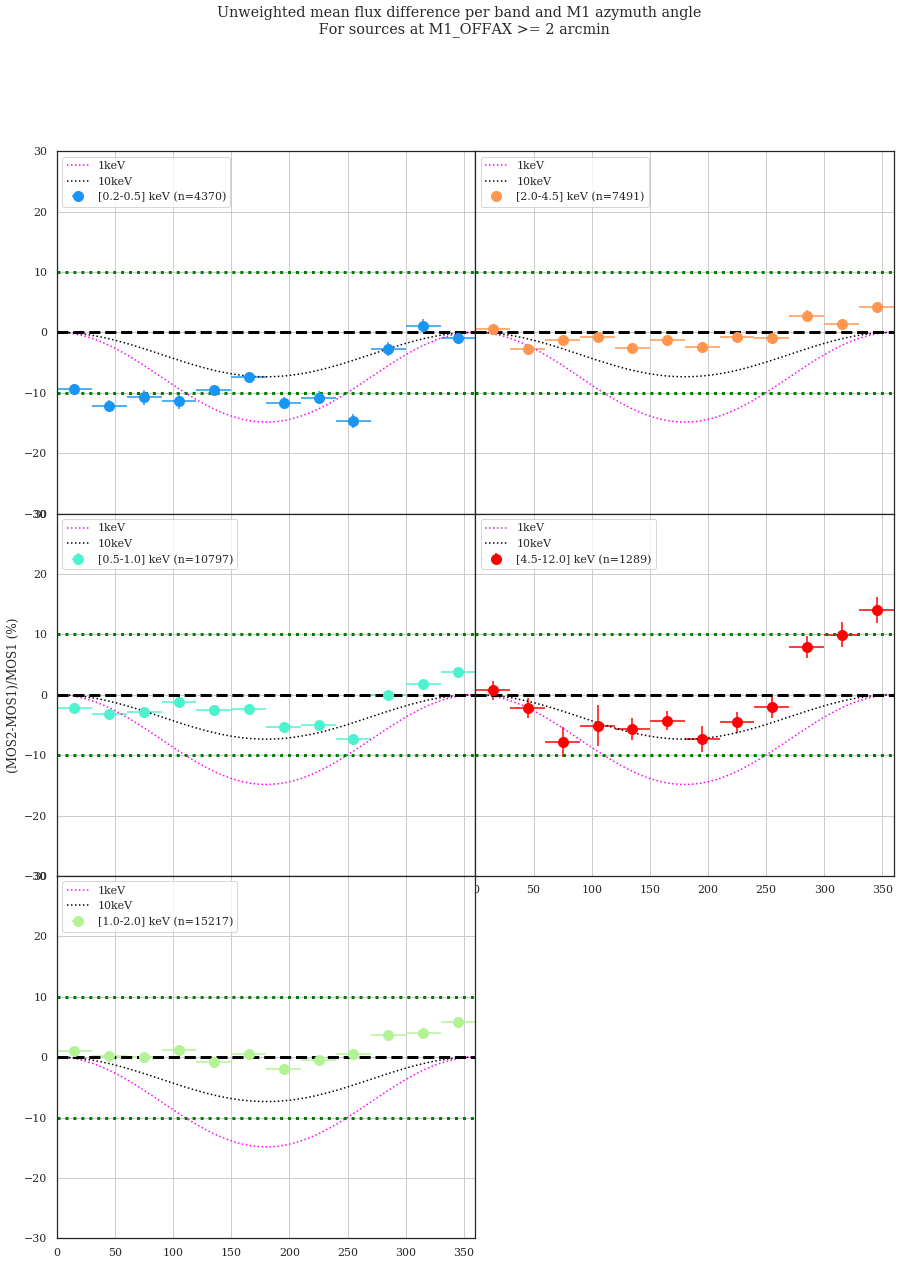

In [214]:
#
fig, axs = plt.subplots(3,2,figsize=(15,20))
#
# azymuthal angle ranges, step 30 deg
xazy = np.arange(0,390,30)
nz = len(xazy)
bands = np.array([1,2,3,4,5])
xcol = cm.rainbow(np.linspace(0, 1, 6))
#xcol = cm.rainbow(np.linspace(0, 1, nz-1))
#
# read the MOS vignetting functions from XMM-SAS calview, there are 4 curves: at 1 and 10 keV and at 3 arcmin and 10 arcmin
#
#
for xband in [1,2,3,4,5]:
    #
    # only select those sources at off-axis angles greater than 2 arcmin
    #
    m1_off = qtsel[xband][f'M1_OFFAX']
    qwork = qtsel[xband].to_pandas()
    qwork = qwork[m1_off >= 2.0]
    nqwork = len(qwork)
    #print (f"Band: {xband}, selected {nqwork} at M1_OFFAX >= 2 arcmin")
    #
    m1_az = qwork[f'M1_phi']
    m2_az = qwork[f'M2_phi']
    #
    m1_fx = qwork[f'M1_{xband}_FLUX']
    m2_fx = qwork[f'M2_{xband}_FLUX']
    pn_fx = qwork[f'PN_{xband}_FLUX']
    #
    m1_fx_err = qwork[f'M1_{xband}_FLUX_ERR']
    m2_fx_err = qwork[f'M2_{xband}_FLUX_ERR']
    pn_fx_err = qwork[f'PN_{xband}_FLUX_ERR']
    #
    # now the ratios and their errors
    #
    ratio1 = (pn_fx/m1_fx - 1.0)*100.0 # in percents
    ratio1_err = np.abs(ratio1)*np.sqrt((m1_fx/m1_fx_err)**2 + (pn_fx/pn_fx_err)**2)
    ratio2 = (pn_fx/m2_fx - 1.0)*100.0 # in percents
    ratio2_err = np.abs(ratio2)*np.sqrt((m2_fx/m2_fx_err)**2 + (pn_fx/pn_fx_err)**2)
    ratio3 = (m2_fx/m1_fx - 1.0)*100.0 # in percents
    ratio3_err = np.abs(ratio3)*np.sqrt((m1_fx/m1_fx_err)**2 + (m2_fx/m2_fx_err)**2)
    #
    # now loop over the azymuths
    #
    rstep = 30.0
    run_az = np.arange(0,390,rstep)
    nep = len(run_az)
    #
    xaz1 = []
    xaz2 = []
    erat1 = []
    erat2 = []
    erat3 = []
    erat1_err = []
    erat2_err = []
    erat3_err = []
    #
    for j in np.arange(nep-1):
        e0 = run_az[j]
        e1 = run_az[j+1]
        ix1 = np.where((m1_az <= e1) & (m1_az > e0))[0]
        if (len(ix1) > 0):
            xaz1.append((e0+e1)/2.0)
            erat1.append(np.mean(ratio1[ix1]))
            erat3.append(np.mean(ratio3[ix1]))
            #erat1_err.append(np.std(ratio1[ix1]))
            #erat3_err.append(np.std(ratio3[ix1]))
            erat1_err.append(sem(ratio1[ix1]))
            erat3_err.append(sem(ratio3[ix1]))
        ix2 = np.where((m2_az <= e1) & (m2_az > e0))[0]
        if (len(ix2) > 0):
            xaz2.append((e0+e1)/2.0)
            erat2.append(np.mean(ratio2[ix2]))
            erat2_err.append(sem(ratio2[ix2]))
            #erat2_err.append(np.std(ratio2[ix2]))
    #
    neq = len(xepo)
    #
    irow = xband-1
    icol = 0
    if (irow > 2):
        icol=1
        irow=irow-3
    panel = irow,icol
    axs[panel].errorbar(xaz2,erat3,xerr=rstep/2.0,yerr=erat3_err,fmt='o',markersize=10,color=xcol[xband],\
                        label=f'{full_bands[xband]} (n={nqwork})')
    #
    # the MOS vignetting function from CCF/calview
    #
    axs[panel].plot(runphi,vig1_10,color='magenta',linestyle='dotted',label="1keV")
    axs[panel].plot(runphi,vig10_10,color='black',linestyle='dotted',label="10keV")
    ###########
    axs[panel].axhline(0.0,color='black',linestyle='--',linewidth=3)
    axs[panel].axhline(-10.0,color='green',linestyle='dotted',linewidth=3)
    axs[panel].axhline(10.0,color='green',linestyle='dotted',linewidth=3)
    axs[panel].grid()
    axs[panel].legend(loc='upper left')
    #axs[panel].set_xlabel('Energy band')
    if (irow==1 and icol==0):
        axs[panel].set_ylabel('(MOS2-MOS1)/MOS1 (%)')
    #axs[0].set_xticks(xband, minor=False)
    axs[panel].set_ylim((-30,30))
    axs[panel].set_xlim((0,360))
    if (icol > 0):
        axs[panel].set_yticklabels([])
    if (irow == 0 or (irow==1 and icol==0)):
        axs[panel].set_xticklabels([])
    #if (irow==0 and icol==0):
    #    axs[panel].set_title('Unweighted mean flux difference per band and M1 azymuth angle \n For sources at M1_OFFAX >= 2 arcmin')
#
plt.suptitle('Unweighted mean flux difference per band and M1 azymuth angle \n For sources at M1_OFFAX >= 2 arcmin')
plt.subplots_adjust(wspace=0, hspace=0)
fig.delaxes(axs[2,1])
plt.savefig(f"{wdir}/3xmm_results_azymuth_mos1_mos2.png",dpi=100)
plt.show()
plt.close();

## Polar plot with $\theta$ and $\phi$ for MOS1 vs PN flux differences

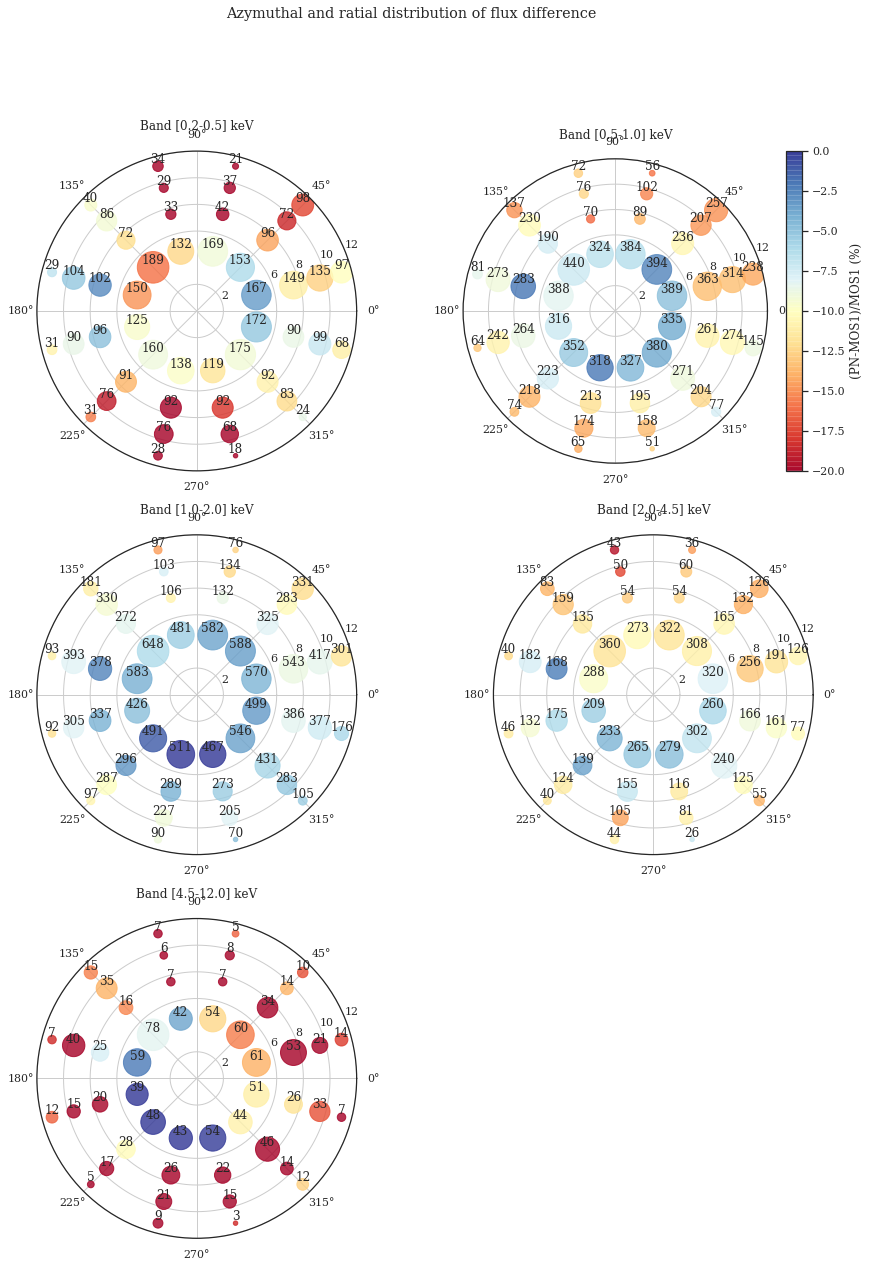

In [200]:
#
#
# polar plot for band=1 and azymuthal angles from 0 to 360 with step 30 deg and 
# 3 equal area offaxis bins from 2 to 12 arcmin.
#
rad_bins = np.array([2.0,6.24,8.60,10.44,12.0],dtype=np.float) # arcmin, equal area bins
nrad = len(rad_bins)
# azymuthal bins of 30 degrees
xazy = np.arange(0,390,30)
nz = len(xazy)
#
xband = 5

fig = plt.figure(figsize=(15,20))
#ax = fig.add_subplot(1,1,1, projection='polar')
cmx = plt.cm.get_cmap('RdYlBu')

for xband in [1,2,3,4,5]:
    ax = fig.add_subplot(3,2,xband, projection='polar')

    m1_off = qtsel[xband][f'M1_OFFAX']
    qwork = qtsel[xband]

    xaz = []
    rrun = []
    erat1 = []
    #erat2 = []
    #erat3 = []
    erat1_err = []
    ncounts = []
    #erat2_err = []
    #erat3_err = []
    #

    for ir in np.arange(nrad-1):
        r0 = rad_bins[ir]
        r1 = rad_bins[ir+1]
        rmean = math.sqrt((r1*r1 + r0*r0)/2.0)
        #print (f"Doing radial bin {r0} to {r1} with mean {rmean}")
        qtemp = qwork[(m1_off >= r0) & (m1_off < r1)]
        #
        m1_az = qtemp[f'M1_phi']
        #
        m1_fx = qtemp[f'M1_{xband}_FLUX']
        m2_fx = qtemp[f'M2_{xband}_FLUX']
        pn_fx = qtemp[f'PN_{xband}_FLUX']
        #
        m1_fx_err = qtemp[f'M1_{xband}_FLUX_ERR']
        m2_fx_err = qtemp[f'M2_{xband}_FLUX_ERR']
        pn_fx_err = qtemp[f'PN_{xband}_FLUX_ERR']
        #
        # now the ratios
        #
        ratio1 = (pn_fx/m1_fx - 1.0)*100.0 # in percents
        ratio2 = (pn_fx/m2_fx - 1.0)*100.0 # in percents
        ratio3 = (m2_fx/m1_fx - 1.0)*100.0 # in percents
        #
        # now loop over the azymuths
        #
        for iz in np.arange(nz-1):
            z0 = xazy[iz]
            z1 = xazy[iz+1]
            ix1 = np.where((m1_az <= z1) & (m1_az > z0))[0]
            if (len(ix1) > 0):
                xaz.append((z0+z1)/2.0)
                rrun.append(rmean)
                erat1.append(np.mean(ratio1[ix1]))
                erat1_err.append(sem(ratio1[ix1]))
                ncounts.append(len(ix1))
            else:
                continue
        #
    theta = np.array(xaz)*math.pi/180.0 # in radians
    colors = erat1
    #colors = np.linspace(-20.0,0.0,len(erat1))
    #area = 10*np.array(rrun)**2
    area = 10*np.array(ncounts)
    # rescale area to be between 200 and 1000
    area = 980*(area - np.min(area))/(np.max(area) - np.min(area)) + 20.0
    p1 = ax.scatter(theta,rrun,c=colors,cmap=cmx,s=area,alpha=0.8,vmin=-20.0,vmax=0.0)
    #ax.set_yticklabels([])
    ax.set_yticks([2.0,6,8.0,10.0,12.0])
    ax.set_ylim((0,12))
    ax.set_title(f'Band {full_bands[xband]}')
    if (xband == 2):
        cbar = plt.colorbar(p1)
        cbar.set_label('(PN-MOS1)/MOS1 (%)');
    #
    # label points with number of sources
    ntx = len(theta)
    for ij in np.arange(ntx):
        plt.text(theta[ij], rrun[ij], f"{ncounts[ij]}",
                 horizontalalignment='center',
                 verticalalignment='bottom')
fig.suptitle('Azymuthal and ratial distribution of flux difference')
#plt.subplots_adjust(wspace=0.1, hspace=0)
plt.savefig(f"{wdir}/3xmm_results_azymuth_theta_mos1_pn.png",dpi=100)
plt.show()
plt.close();

## Polar plot of $\theta$ and $\phi$ for MOS2 vs PN flux differences

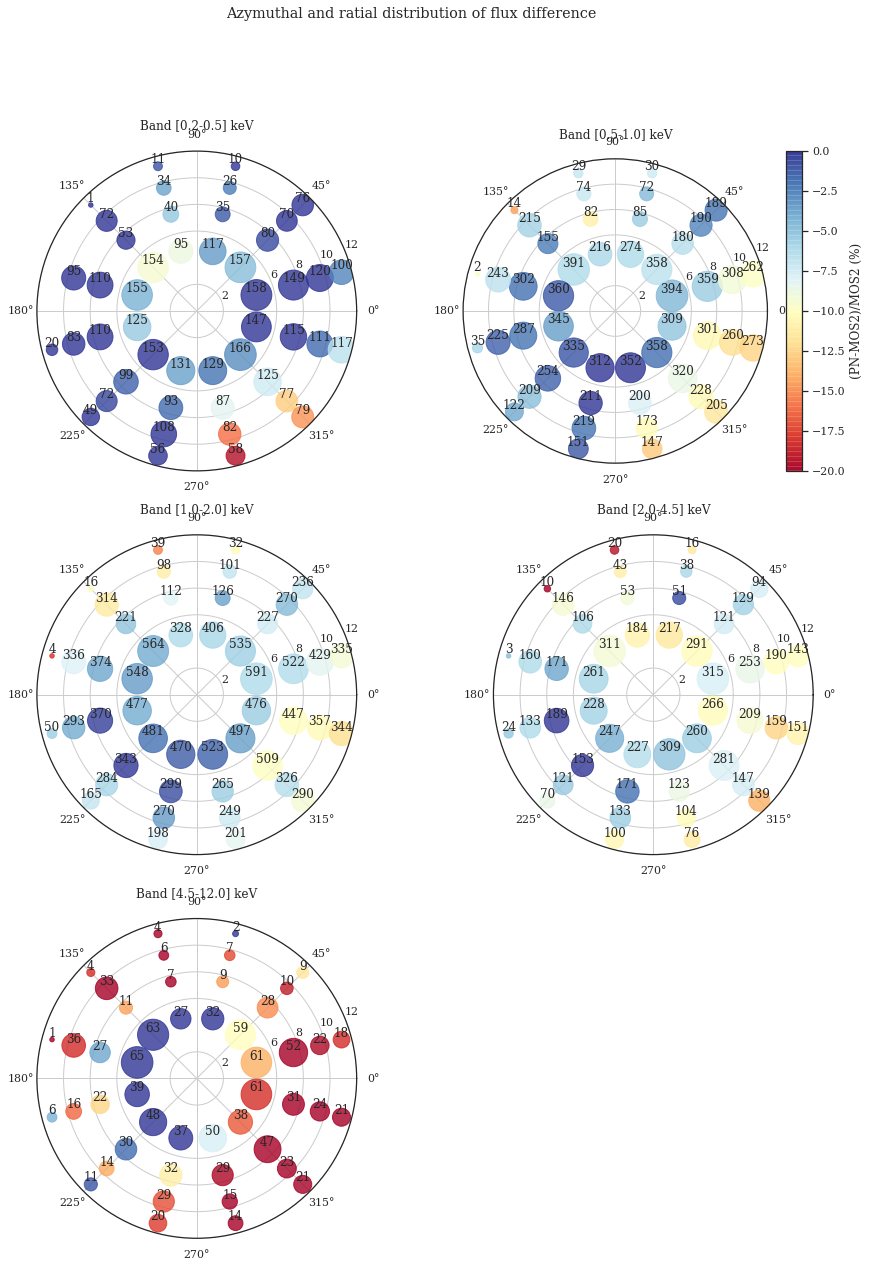

In [206]:
#
#
# polar plot for band=1 and azymuthal angles from 0 to 360 with step 30 deg and 
# 3 equal area offaxis bins from 2 to 12 arcmin.
#
rad_bins = np.array([2.0,6.24,8.60,10.44,12.0],dtype=np.float) # arcmin, equal area bins
nrad = len(rad_bins)
# azymuthal bins of 30 degrees
xazy = np.arange(0,390,30)
nz = len(xazy)
#
xband = 5

fig = plt.figure(figsize=(15,20))
#ax = fig.add_subplot(1,1,1, projection='polar')
cmx = plt.cm.get_cmap('RdYlBu')

for xband in [1,2,3,4,5]:
    ax = fig.add_subplot(3,2,xband, projection='polar')

    m2_off = qtsel[xband][f'M2_OFFAX']
    qwork = qtsel[xband]

    xaz = []
    rrun = []
    erat2 = []
    #erat2 = []
    #erat3 = []
    erat2_err = []
    ncounts = []
    #erat2_err = []
    #erat3_err = []
    #

    for ir in np.arange(nrad-1):
        r0 = rad_bins[ir]
        r1 = rad_bins[ir+1]
        rmean = math.sqrt((r1*r1 + r0*r0)/2.0)
        #print (f"Doing radial bin {r0} to {r1} with mean {rmean}")
        qtemp = qwork[(m2_off >= r0) & (m2_off < r1)]
        #
        m2_az = qtemp[f'M2_phi']
        #
        m1_fx = qtemp[f'M1_{xband}_FLUX']
        m2_fx = qtemp[f'M2_{xband}_FLUX']
        pn_fx = qtemp[f'PN_{xband}_FLUX']
        #
        m1_fx_err = qtemp[f'M1_{xband}_FLUX_ERR']
        m2_fx_err = qtemp[f'M2_{xband}_FLUX_ERR']
        pn_fx_err = qtemp[f'PN_{xband}_FLUX_ERR']
        #
        # now the ratios
        #
        ratio1 = (pn_fx/m1_fx - 1.0)*100.0 # in percents
        ratio2 = (pn_fx/m2_fx - 1.0)*100.0 # in percents
        ratio3 = (m2_fx/m1_fx - 1.0)*100.0 # in percents
        #
        # now loop over the azymuths
        #
        for iz in np.arange(nz-1):
            z0 = xazy[iz]
            z1 = xazy[iz+1]
            ix1 = np.where((m2_az <= z1) & (m2_az > z0))[0]
            if (len(ix1) > 0):
                xaz.append((z0+z1)/2.0)
                rrun.append(rmean)
                erat2.append(np.mean(ratio2[ix1]))
                erat2_err.append(np.mean(ratio2_err[ix1]))
                ncounts.append(len(ix1))
            else:
                continue
        #
    theta = np.array(xaz)*math.pi/180.0 # in radians
    colors = erat2
    #colors = np.linspace(-20.0,0.0,len(erat1))
    #area = 10*np.array(rrun)**2
    area = 10*np.array(ncounts)
    # rescale area to be between 200 and 1000
    area = 980*(area - np.min(area))/(np.max(area) - np.min(area)) + 20.0
    p1 = ax.scatter(theta,rrun,c=colors,cmap=cmx,s=area,alpha=0.8,vmin=-20.0,vmax=0.0)
    #ax.set_yticklabels([])
    ax.set_yticks([2.0,6,8.0,10.0,12.0])
    ax.set_ylim((0,12))
    ax.set_title(f'Band {full_bands[xband]}')
    if (xband == 2):
        cbar = plt.colorbar(p1)
        cbar.set_label('(PN-MOS2)/MOS2 (%)');
    #
    # label points with number of sources
    ntx = len(theta)
    for ij in np.arange(ntx):
        plt.text(theta[ij], rrun[ij], f"{ncounts[ij]}",
                 horizontalalignment='center',
                 verticalalignment='bottom')
fig.suptitle('Azymuthal and ratial distribution of flux difference')
#plt.subplots_adjust(wspace=0.1, hspace=0)
plt.savefig(f"{wdir}/3xmm_results_azymuth_theta_mos2_pn.png",dpi=100)
plt.show()
plt.close();

## Polar plot of $\theta$ and $\phi$ for MOS1 vs MOS2 flux differences

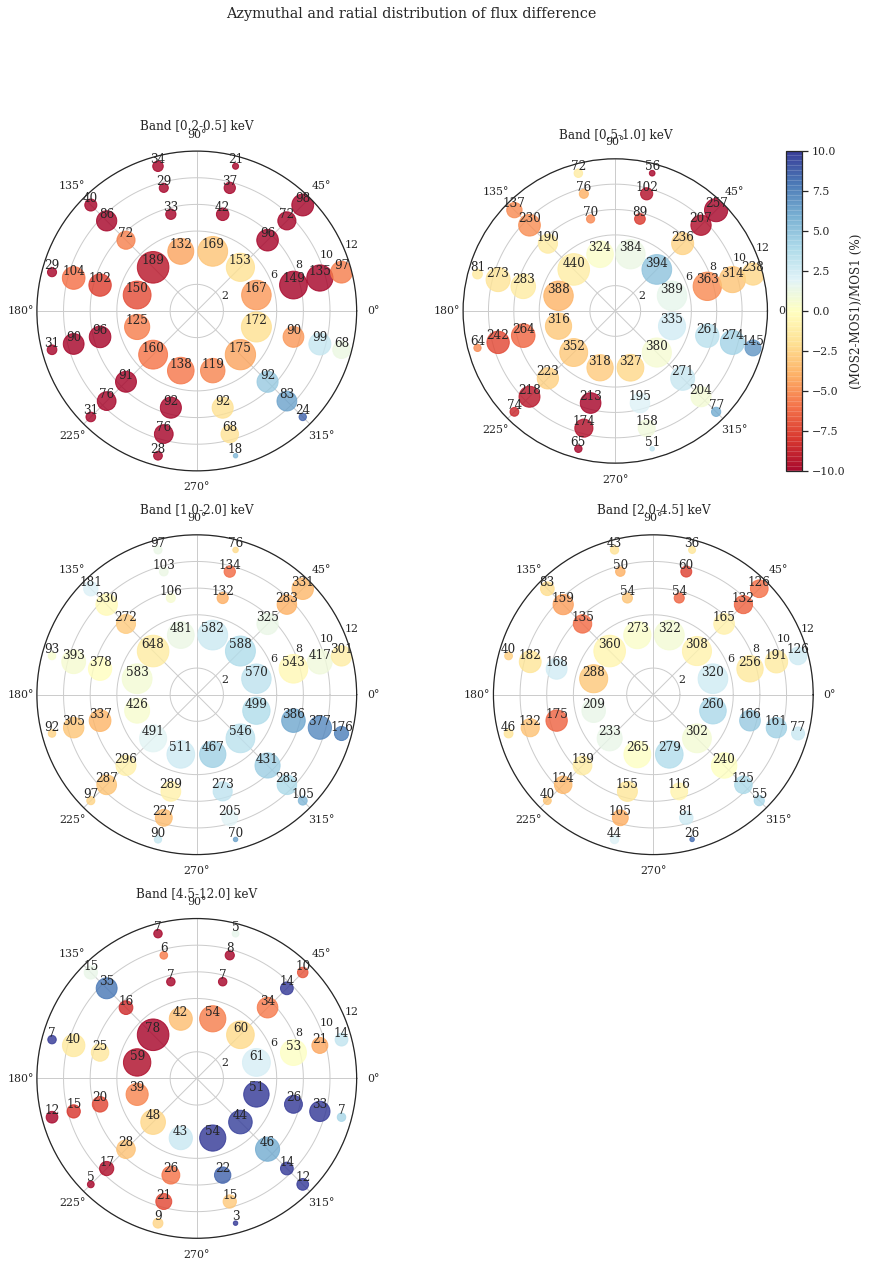

In [211]:
#
#
# polar plot for band=1 and azymuthal angles from 0 to 360 with step 30 deg and 
# 3 equal area offaxis bins from 2 to 12 arcmin.
#
rad_bins = np.array([2.0,6.24,8.60,10.44,12.0],dtype=np.float) # arcmin, equal area bins
nrad = len(rad_bins)
# azymuthal bins of 30 degrees
xazy = np.arange(0,390,30)
nz = len(xazy)
#
xband = 5

fig = plt.figure(figsize=(15,20))
#ax = fig.add_subplot(1,1,1, projection='polar')
cmx = plt.cm.get_cmap('RdYlBu')

for xband in [1,2,3,4,5]:
    ax = fig.add_subplot(3,2,xband, projection='polar')

    m1_off = qtsel[xband][f'M1_OFFAX']
    qwork = qtsel[xband]

    xaz = []
    rrun = []
    erat3 = []
    #erat2 = []
    #erat3 = []
    erat3_err = []
    ncounts = []
    #erat2_err = []
    #erat3_err = []
    #

    for ir in np.arange(nrad-1):
        r0 = rad_bins[ir]
        r1 = rad_bins[ir+1]
        rmean = math.sqrt((r1*r1 + r0*r0)/2.0)
        #print (f"Doing radial bin {r0} to {r1} with mean {rmean}")
        qtemp = qwork[(m1_off >= r0) & (m1_off < r1)]
        #
        m1_az = qtemp[f'M1_phi']
        #
        m1_fx = qtemp[f'M1_{xband}_FLUX']
        m2_fx = qtemp[f'M2_{xband}_FLUX']
        pn_fx = qtemp[f'PN_{xband}_FLUX']
        #
        m1_fx_err = qtemp[f'M1_{xband}_FLUX_ERR']
        m2_fx_err = qtemp[f'M2_{xband}_FLUX_ERR']
        pn_fx_err = qtemp[f'PN_{xband}_FLUX_ERR']
        #
        # now the ratios
        #
        ratio1 = (pn_fx/m1_fx - 1.0)*100.0 # in percents
        ratio2 = (pn_fx/m2_fx - 1.0)*100.0 # in percents
        ratio3 = (m2_fx/m1_fx - 1.0)*100.0 # in percents
        #
        # now loop over the azymuths
        #
        for iz in np.arange(nz-1):
            z0 = xazy[iz]
            z1 = xazy[iz+1]
            ix1 = np.where((m1_az <= z1) & (m1_az > z0))[0]
            if (len(ix1) > 0):
                xaz.append((z0+z1)/2.0)
                rrun.append(rmean)
                erat3.append(np.mean(ratio3[ix1]))
                erat3_err.append(np.mean(ratio3_err[ix1]))
                ncounts.append(len(ix1))
            else:
                continue
        #
    theta = np.array(xaz)*math.pi/180.0 # in radians
    colors = erat3
    #colors = np.linspace(-20.0,0.0,len(erat1))
    #area = 10*np.array(rrun)**2
    area = 10*np.array(ncounts)
    # rescale area to be between 200 and 1000
    area = 980*(area - np.min(area))/(np.max(area) - np.min(area)) + 20.0
    p1 = ax.scatter(theta,rrun,c=colors,cmap=cmx,s=area,alpha=0.8,vmin=-10.0,vmax=10.0)
    #ax.set_yticklabels([])
    ax.set_yticks([2.0,6,8.0,10.0,12.0])
    ax.set_ylim((0,12))
    ax.set_title(f'Band {full_bands[xband]}')
    if (xband == 2):
        cbar = plt.colorbar(p1)
        cbar.set_label('(MOS2-MOS1)/MOS1 (%)');
    #
    # label points with number of sources
    ntx = len(theta)
    for ij in np.arange(ntx):
        plt.text(theta[ij], rrun[ij], f"{ncounts[ij]}",
                 horizontalalignment='center',
                 verticalalignment='bottom')
fig.suptitle('Azymuthal and ratial distribution of flux difference')
#plt.subplots_adjust(wspace=0.1, hspace=0)
plt.savefig(f"{wdir}/3xmm_results_azymuth_theta_mos1_mos2.png",dpi=100)
plt.show()
plt.close();